In [55]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost as xgb
import os
import pickle

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.svm import SVR
from scipy.stats import randint, uniform
import xgboost


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## process weather data

In [6]:
weather_data = pd.read_csv("/content/drive/MyDrive/MDA_TIEN/weather_data_leuven.csv")

In [7]:
weather_data.head(4)

,time,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),precipitation (mm),rain (mm),snowfall (cm),...,cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),winddirection_10m (°),windgusts_10m (km/h)
0,2022-01-01T00:00,12.7,92,11.5,10.9,1023.6,1020.4,0.0,0.0,0.0,...,92,0,93,0,0,0,0.0,15.3,243,30.2
1,2022-01-01T01:00,12.7,92,11.5,11.2,1024.0,1020.8,0.0,0.0,0.0,...,84,0,97,0,0,0,0.0,13.4,243,26.6
2,2022-01-01T02:00,12.6,93,11.4,12.0,1023.7,1020.5,0.0,0.0,0.0,...,85,1,82,0,0,0,0.0,6.9,242,27.0
3,2022-01-01T03:00,12.5,93,11.3,11.7,1024.4,1021.2,0.0,0.0,0.0,...,96,4,34,0,0,0,0.0,7.6,239,28.4


In [8]:
weather_data.columns

Index(['time', 'temperature_2m (°C)', 'relativehumidity_2m (%)',
       'dewpoint_2m (°C)', 'apparent_temperature (°C)', 'pressure_msl (hPa)',
       'surface_pressure (hPa)', 'precipitation (mm)', 'rain (mm)',
       'snowfall (cm)', 'weathercode (wmo code)', 'cloudcover (%)',
       'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)',
       'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)',
       'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)',
       'windspeed_10m (km/h)', 'winddirection_10m (°)',
       'windgusts_10m (km/h)'],
      dtype='object')

In [9]:
import re
## rename the column
weather_data.columns = [re.sub(' \(.*\)', "", col) for col in weather_data.columns]

In [10]:
weather_data.head(2)

,time,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,...,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m
0,2022-01-01T00:00,12.7,92,11.5,10.9,1023.6,1020.4,0.0,0.0,0.0,...,92,0,93,0,0,0,0.0,15.3,243,30.2
1,2022-01-01T01:00,12.7,92,11.5,11.2,1024.0,1020.8,0.0,0.0,0.0,...,84,0,97,0,0,0,0.0,13.4,243,26.6


In [11]:
weather_data.dtypes

time                         object
temperature_2m              float64
relativehumidity_2m           int64
dewpoint_2m                 float64
apparent_temperature        float64
pressure_msl                float64
surface_pressure            float64
precipitation               float64
rain                        float64
snowfall                    float64
weathercode                   int64
cloudcover                    int64
cloudcover_low                int64
cloudcover_mid                int64
cloudcover_high               int64
shortwave_radiation           int64
direct_radiation              int64
diffuse_radiation             int64
direct_normal_irradiance    float64
windspeed_10m               float64
winddirection_10m             int64
windgusts_10m               float64
dtype: object

In [12]:
np.unique(weather_data.weathercode)

array([ 0,  1,  2,  3, 51, 53, 55, 61, 63, 65, 71, 73])

In [13]:
# extract from timestamp
weather_data["time"] = pd.to_datetime(weather_data['time'])
weather_data['date'] = weather_data['time'].dt.date
weather_data['hour'] = weather_data['time'].dt.hour
weather_data["month"] = weather_data["time"].dt.month
weather_data['weekday'] = weather_data['time'].dt.strftime('%a')
weather_data.head(5)

,time,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,...,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m,date,hour,month,weekday
0,2022-01-01 00:00:00,12.7,92,11.5,10.9,1023.6,1020.4,0.0,0.0,0.0,...,0,0,0.0,15.3,243,30.2,2022-01-01,0,1,Sat
1,2022-01-01 01:00:00,12.7,92,11.5,11.2,1024.0,1020.8,0.0,0.0,0.0,...,0,0,0.0,13.4,243,26.6,2022-01-01,1,1,Sat
2,2022-01-01 02:00:00,12.6,93,11.4,12.0,1023.7,1020.5,0.0,0.0,0.0,...,0,0,0.0,6.9,242,27.0,2022-01-01,2,1,Sat
3,2022-01-01 03:00:00,12.5,93,11.3,11.7,1024.4,1021.2,0.0,0.0,0.0,...,0,0,0.0,7.6,239,28.4,2022-01-01,3,1,Sat
4,2022-01-01 04:00:00,12.3,93,11.2,11.7,1024.3,1021.1,0.0,0.0,0.0,...,0,0,0.0,6.4,232,26.6,2022-01-01,4,1,Sat


In [14]:
weather_data.drop("time", axis = 1, inplace = True)

In [15]:
weather_data.shape

(8760, 25)

In [16]:
weather_data.head(3)

,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,weathercode,...,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m,date,hour,month,weekday
0,12.7,92,11.5,10.9,1023.6,1020.4,0.0,0.0,0.0,3,...,0,0,0.0,15.3,243,30.2,2022-01-01,0,1,Sat
1,12.7,92,11.5,11.2,1024.0,1020.8,0.0,0.0,0.0,3,...,0,0,0.0,13.4,243,26.6,2022-01-01,1,1,Sat
2,12.6,93,11.4,12.0,1023.7,1020.5,0.0,0.0,0.0,3,...,0,0,0.0,6.9,242,27.0,2022-01-01,2,1,Sat


## process air quality data

In [17]:
air_quality_data = pd.read_csv("/content/drive/MyDrive/MDA_TIEN/air_quality_full.csv")

In [18]:
air_quality_data.head(3)

,Unnamed: 0,dt,pm2_5,pm10,co,no2,o3,so2,nh3
0,0,2022-01-01 01:00:00,3.68,5.20,253.68,8.83,39.34,1.82,0.79
1,1,2022-01-01 02:00:00,3.69,5.27,250.34,8.05,38.62,1.86,0.79
2,2,2022-01-01 03:00:00,3.44,4.99,247.00,7.11,38.27,1.71,0.78


In [19]:
air_quality_data.columns

Index(['Unnamed: 0', 'dt', 'pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2', 'nh3'], dtype='object')

In [20]:
air_quality_data.drop(['Unnamed: 0'], inplace = True, axis  = 1)

In [21]:
air_quality_data.head(3)

,dt,pm2_5,pm10,co,no2,o3,so2,nh3
0,2022-01-01 01:00:00,3.68,5.20,253.68,8.83,39.34,1.82,0.79
1,2022-01-01 02:00:00,3.69,5.27,250.34,8.05,38.62,1.86,0.79
2,2022-01-01 03:00:00,3.44,4.99,247.00,7.11,38.27,1.71,0.78


In [22]:
# extract from timestamp
air_quality_data["dt"] = pd.to_datetime(air_quality_data['dt'])
air_quality_data['date'] = air_quality_data['dt'].dt.date
air_quality_data['hour'] = air_quality_data['dt'].dt.hour
air_quality_data["month"] = air_quality_data["dt"].dt.month
air_quality_data['weekday'] = air_quality_data['dt'].dt.strftime('%a')
air_quality_data.head(5)

,dt,pm2_5,pm10,co,no2,o3,so2,nh3,date,hour,month,weekday
0,2022-01-01 01:00:00,3.68,5.20,253.68,8.83,39.34,1.82,0.79,2022-01-01,1,1,Sat
1,2022-01-01 02:00:00,3.69,5.27,250.34,8.05,38.62,1.86,0.79,2022-01-01,2,1,Sat
2,2022-01-01 03:00:00,3.44,4.99,247.00,7.11,38.27,1.71,0.78,2022-01-01,3,1,Sat
3,2022-01-01 04:00:00,2.93,4.26,243.66,6.17,38.62,1.33,0.72,2022-01-01,4,1,Sat
4,2022-01-01 05:00:00,3.02,4.07,257.02,6.85,37.19,1.03,0.68,2022-01-01,5,1,Sat


In [23]:
air_quality_data = air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()

<ipython-input-23-ee8ad7f9babb>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  air_quality_data = air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()


In [24]:
air_quality_data

,date,hour,month,weekday,pm2_5,pm10,co,no2,o3,so2,nh3
0,2022-01-01,1,1,Sat,3.68,5.20,253.68,8.83,39.34,1.82,0.79
1,2022-01-01,2,1,Sat,3.69,5.27,250.34,8.05,38.62,1.86,0.79
2,2022-01-01,3,1,Sat,3.44,4.99,247.00,7.11,38.27,1.71,0.78
3,2022-01-01,4,1,Sat,2.93,4.26,243.66,6.17,38.62,1.33,0.72
4,2022-01-01,5,1,Sat,3.02,4.07,257.02,6.85,37.19,1.03,0.68
...,...,...,...,...,...,...,...,...,...,...,...
8587,2022-12-31,21,12,Sat,4.05,5.78,220.30,6.00,61.51,1.12,1.41
8588,2022-12-31,22,12,Sat,4.12,6.10,216.96,5.31,62.94,1.03,1.36
8589,2022-12-31,23,12,Sat,4.19,6.58,213.62,4.58,65.09,0.92,1.31
8590,2023-01-01,0,1,Sun,4.28,7.12,210.29,3.73,67.23,0.81,1.30


## process file42 data

In [25]:
file42 = pd.read_csv("/content/drive/MyDrive/MDA_TIEN/file42.csv")

In [26]:
file42.dropna(inplace = True)

In [27]:
file42.head(5)

,Unnamed: 0,result_timestamp,#object_id,lamax,laeq,lceq,lcpeak,hour,weekday,month,location
0,8203,2022-02-28 08:00:00,255439.0,58.679893,56.965367,67.359289,78.976896,8,Mon,2,MP 01: Naamsestraat 35 Maxim
5,8208,2022-02-28 13:00:00,255439.0,57.610063,55.556352,64.805270,76.718642,13,Mon,2,MP 01: Naamsestraat 35 Maxim
6,8209,2022-02-28 14:00:00,255439.0,57.101721,55.100833,64.435944,76.297757,14,Mon,2,MP 01: Naamsestraat 35 Maxim
7,8210,2022-02-28 15:00:00,255439.0,56.258222,54.167056,62.930547,75.222819,15,Mon,2,MP 01: Naamsestraat 35 Maxim
8,8211,2022-02-28 16:00:00,255439.0,57.101444,54.979111,63.220742,75.562858,16,Mon,2,MP 01: Naamsestraat 35 Maxim


In [28]:
file42.columns

Index(['Unnamed: 0', 'result_timestamp', '#object_id', 'lamax', 'laeq', 'lceq',
       'lcpeak', 'hour', 'weekday', 'month', 'location'],
      dtype='object')

In [29]:
file42.drop("Unnamed: 0", axis = 1, inplace = True)

In [30]:
file42.rename(columns={'#object_id': 'object_id'}, inplace=True)

In [31]:
file42["object_id"] = pd.to_numeric(file42["object_id"]).astype(int)

In [32]:
file42.head(5)

,result_timestamp,object_id,lamax,laeq,lceq,lcpeak,hour,weekday,month,location
0,2022-02-28 08:00:00,255439,58.679893,56.965367,67.359289,78.976896,8,Mon,2,MP 01: Naamsestraat 35 Maxim
5,2022-02-28 13:00:00,255439,57.610063,55.556352,64.805270,76.718642,13,Mon,2,MP 01: Naamsestraat 35 Maxim
6,2022-02-28 14:00:00,255439,57.101721,55.100833,64.435944,76.297757,14,Mon,2,MP 01: Naamsestraat 35 Maxim
7,2022-02-28 15:00:00,255439,56.258222,54.167056,62.930547,75.222819,15,Mon,2,MP 01: Naamsestraat 35 Maxim
8,2022-02-28 16:00:00,255439,57.101444,54.979111,63.220742,75.562858,16,Mon,2,MP 01: Naamsestraat 35 Maxim


In [33]:
# Convert the 'result_timestamp' column to a datetime data type
file42['result_timestamp'] = pd.to_datetime(file42['result_timestamp'])
file42['date'] = file42['result_timestamp'].dt.date
file42['hour'] = file42['result_timestamp'].dt.hour
file42["month"] = file42["result_timestamp"].dt.month
file42['weekday'] = file42['result_timestamp'].dt.strftime('%a')
file42.head(4)

,result_timestamp,object_id,lamax,laeq,lceq,lcpeak,hour,weekday,month,location,date
0,2022-02-28 08:00:00,255439,58.679893,56.965367,67.359289,78.976896,8,Mon,2,MP 01: Naamsestraat 35 Maxim,2022-02-28
5,2022-02-28 13:00:00,255439,57.610063,55.556352,64.805270,76.718642,13,Mon,2,MP 01: Naamsestraat 35 Maxim,2022-02-28
6,2022-02-28 14:00:00,255439,57.101721,55.100833,64.435944,76.297757,14,Mon,2,MP 01: Naamsestraat 35 Maxim,2022-02-28
7,2022-02-28 15:00:00,255439,56.258222,54.167056,62.930547,75.222819,15,Mon,2,MP 01: Naamsestraat 35 Maxim,2022-02-28


In [34]:
file42 = file42.groupby(["object_id", "date", "hour", "month", "weekday"]).mean().reset_index()
file42.head(5)

<ipython-input-34-b56ba3d1b0b2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  file42 = file42.groupby(["object_id", "date", "hour", "month", "weekday"]).mean().reset_index()


,object_id,date,hour,month,weekday,lamax,laeq,lceq,lcpeak
0,255439,2022-02-28,8,2,Mon,58.679893,56.965367,67.359289,78.976896
1,255439,2022-02-28,13,2,Mon,57.610063,55.556352,64.805270,76.718642
2,255439,2022-02-28,14,2,Mon,57.101721,55.100833,64.435944,76.297757
3,255439,2022-02-28,15,2,Mon,56.258222,54.167056,62.930547,75.222819
4,255439,2022-02-28,16,2,Mon,57.101444,54.979111,63.220742,75.562858


## Merge data

In [35]:
data_model = file42.merge(air_quality_data, how = "inner",
                          left_on = ["date", "hour", "month", "weekday"],
                          right_on = ["date", "hour", "month", "weekday"])

In [36]:
data_model = data_model.merge(weather_data, how = "inner",
                          left_on = ["date", "hour", "month", "weekday"],
                          right_on = ["date", "hour", "month", "weekday"])

In [37]:
data_model.shape  

(54413, 37)

In [38]:
data_model.head(5)

,object_id,date,hour,month,weekday,lamax,laeq,lceq,lcpeak,pm2_5,...,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m
0,255439,2022-02-28,8,2,Mon,58.679893,56.965367,67.359289,78.976896,9.27,...,0,0,0,0,0,0,0.0,11.9,295,16.2
1,255441,2022-02-28,8,2,Mon,55.492778,54.066667,65.229694,76.438689,9.27,...,0,0,0,0,0,0,0.0,11.9,295,16.2
2,255442,2022-02-28,8,2,Mon,55.842472,54.106667,63.679853,75.430328,9.27,...,0,0,0,0,0,0,0.0,11.9,295,16.2
3,255443,2022-02-28,8,2,Mon,55.250278,53.569000,63.015794,74.931089,9.27,...,0,0,0,0,0,0,0.0,11.9,295,16.2
4,255444,2022-02-28,8,2,Mon,55.992611,54.480028,64.411319,75.940522,9.27,...,0,0,0,0,0,0,0.0,11.9,295,16.2


In [39]:
data_model.dtypes

object_id                     int64
date                         object
hour                          int64
month                         int64
weekday                      object
lamax                       float64
laeq                        float64
lceq                        float64
lcpeak                      float64
pm2_5                       float64
pm10                        float64
co                          float64
no2                         float64
o3                          float64
so2                         float64
nh3                         float64
temperature_2m              float64
relativehumidity_2m           int64
dewpoint_2m                 float64
apparent_temperature        float64
pressure_msl                float64
surface_pressure            float64
precipitation               float64
rain                        float64
snowfall                    float64
weathercode                   int64
cloudcover                    int64
cloudcover_low              

In [40]:
## split train, test data
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_model, test_size=0.2, random_state = 7)

## process dependent variables

In [41]:
target_variable = ["lamax", "laeq", "lceq", "lcpeak"]


In [42]:
y_train = train_df[target_variable]
y_train.head(2)

,lamax,laeq,lceq,lcpeak
46575,57.524278,55.794722,63.272894,75.597211
26968,48.282722,46.791806,57.034947,68.439956


In [43]:
y_val = val_df[target_variable]
y_val.head(2)

,lamax,laeq,lceq,lcpeak
38808,42.591306,40.860722,49.396692,62.092933
43213,55.326611,53.388611,61.123072,73.719969


## process independent variables

In [44]:
X_train = train_df.drop(target_variable + ["date"], axis = 1)
X_val = val_df.drop(target_variable + ["date"], axis = 1)

In [45]:
X_train.columns

Index(['object_id', 'hour', 'month', 'weekday', 'pm2_5', 'pm10', 'co', 'no2',
       'o3', 'so2', 'nh3', 'temperature_2m', 'relativehumidity_2m',
       'dewpoint_2m', 'apparent_temperature', 'pressure_msl',
       'surface_pressure', 'precipitation', 'rain', 'snowfall', 'weathercode',
       'cloudcover', 'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
       'shortwave_radiation', 'direct_radiation', 'diffuse_radiation',
       'direct_normal_irradiance', 'windspeed_10m', 'winddirection_10m',
       'windgusts_10m'],
      dtype='object')

In [46]:
one_hot_var = ["hour", "month", "weekday", "object_id", "weathercode"]
numerical_var = [col for col in X_train.columns if col not in one_hot_var]

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
t = ColumnTransformer(
    transformers = [
        ('OneHot', OneHotEncoder(handle_unknown='ignore'), one_hot_var),
        ('StandardScaler', StandardScaler(), numerical_var)
        
    ])

# fit the encoder
t.fit(X_train, y_train)


ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['hour', 'month', 'weekday', 'object_id',
                                  'weathercode']),
                                ('StandardScaler', StandardScaler(),
                                 ['pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2',
                                  'nh3', 'temperature_2m',
                                  'relativehumidity_2m', 'dewpoint_2m',
                                  'apparent_temperature', 'pressure_msl',
                                  'surface_pressure', 'precipitation', 'rain',
                                  'snowfall', 'cloudcover', 'cloudcover_low',
                                  'cloudcover_mid', 'cloudcover_high',
                                  'shortwave_radiation', 'direct_radiation',
                                  'diffuse_radiation',
                                  'direct_normal_irradiance', 'windspeed_10m',
                                  'winddirection_10m', 'windgusts_10m'])])

In [48]:
## save columnstransformer

with open('/content/drive/MyDrive/MDA_TIEN/encoder_model2.pkl', 'wb') as file:
    pickle.dump(t, file)

In [49]:
# create pandas DataFrame from dense matrix
X_train = pd.DataFrame(t.fit_transform(X_train), columns=t.get_feature_names_out())

X_val = pd.DataFrame(t.transform(X_val), columns=t.get_feature_names_out())

In [50]:
X_train.columns

Index(['OneHot__hour_0', 'OneHot__hour_1', 'OneHot__hour_2', 'OneHot__hour_3',
       'OneHot__hour_4', 'OneHot__hour_5', 'OneHot__hour_6', 'OneHot__hour_7',
       'OneHot__hour_8', 'OneHot__hour_9', 'OneHot__hour_10',
       'OneHot__hour_11', 'OneHot__hour_12', 'OneHot__hour_13',
       'OneHot__hour_14', 'OneHot__hour_15', 'OneHot__hour_16',
       'OneHot__hour_17', 'OneHot__hour_18', 'OneHot__hour_19',
       'OneHot__hour_20', 'OneHot__hour_21', 'OneHot__hour_22',
       'OneHot__hour_23', 'OneHot__month_1', 'OneHot__month_2',
       'OneHot__month_3', 'OneHot__month_4', 'OneHot__month_5',
       'OneHot__month_6', 'OneHot__month_7', 'OneHot__month_8',
       'OneHot__month_9', 'OneHot__month_10', 'OneHot__month_11',
       'OneHot__month_12', 'OneHot__weekday_Fri', 'OneHot__weekday_Mon',
       'OneHot__weekday_Sat', 'OneHot__weekday_Sun', 'OneHot__weekday_Thu',
       'OneHot__weekday_Tue', 'OneHot__weekday_Wed',
       'OneHot__object_id_255439', 'OneHot__object_id_255440',
 

In [51]:
y_train.columns

Index(['lamax', 'laeq', 'lceq', 'lcpeak'], dtype='object')

## predict lamax

In [161]:
# Define the model parameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'max_depth': randint(3, 50),
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }
    },
    
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 1),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
        }
    }
    
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train['lamax'])
    
    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

    '''
    Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 85}
Best score for random_forest:  0.8631852259540297


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.4289589971546303, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 71}
Best score for gradient_boosting:  0.8801165460206839


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.13316944575925016, 'learning_rate': 0.2717062903368829, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 98, 'reg_alpha': 0.19335562339240953, 'reg_lambda': 0.100473971701034}
Best score for xgboost:  0.8956961049403812'''

Running RandomizedSearchCV for random_forest...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 85}
Best score for random_forest:  0.8631852259540297


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.4289589971546303, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 71}
Best score for gradient_boosting:  0.8801165460206839


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.13316944575925016, 'learning_rate': 0.2717062903368829, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 98, 'reg_alpha': 0.19335562339240953, 'reg_lambda': 0.100473971701034}
Best score for xgboost:  0.8956961049403812




In [162]:
# Save optimal param dictionary
pickle.dump(params_dict,open("/content/drive/MyDrive/MDA_TIEN/lamax_dict","wb"))

In [53]:
# Load param dictionary 
lamax_dict = pickle.load(open("/content/drive/MyDrive/MDA_TIEN/lamax_dict", "rb"))
lamax_dict

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [57]:
gb_params = lamax_dict['gradient_boosting']

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["lamax"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lamax"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lamax"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lamax"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lamax"]))

Train RMSE: 1.4280491175931176
Val RMSE: 2.0558287405869047
Train MAE: 0.9946501592697466
Val MAE: 1.3868413148756473


In [58]:
rf_params = lamax_dict['random_forest']

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["lamax"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lamax"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lamax"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lamax"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lamax"]))

Train RMSE: 1.1060793551980486
Val RMSE: 2.1701450325435836
Train MAE: 0.7494223128531653
Val MAE: 1.4579371305789268


In [59]:
import xgboost

xgb_params = lamax_dict['xgboost']

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["lamax"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lamax"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lamax"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lamax"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lamax"]))

Train RMSE: 1.0863792982579672
Val RMSE: 1.886690541616359
Train MAE: 0.7641576094868555
Val MAE: 1.2553625466133227


Text(0, 0.5, 'y val')

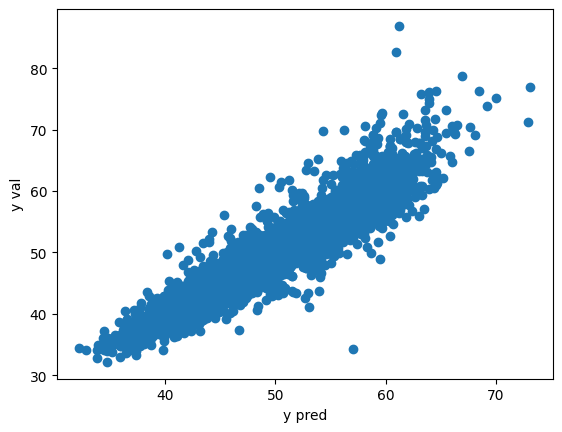

In [60]:
plt.scatter(val_preds, y_val["lamax"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [61]:
r2_score(val_preds, y_val["lamax"])

0.8969124218987571

In [62]:
## save model 

import pickle

pickle.dump(xgb, open('/content/drive/MyDrive/MDA_TIEN/xgb_lamax.pkl', 'wb'))

## predict laeq

In [163]:
# Define the model parameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'max_depth': randint(3, 50),
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }
    },
    
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 1),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
        }
    }
    
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train['laeq'])
    
    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")


Running RandomizedSearchCV for random_forest...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 85}
Best score for random_forest:  0.86698648936162


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.4289589971546303, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 71}
Best score for gradient_boosting:  0.8853969949238698


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.13316944575925016, 'learning_rate': 0.2717062903368829, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 98, 'reg_alpha': 0.19335562339240953, 'reg_lambda': 0.100473971701034}
Best score for xgboost:  0.9003669229557906




In [164]:
# Save optimal param dictionary
pickle.dump(params_dict,open("/content/drive/MyDrive/MDA_TIEN/laeq_dict","wb"))

In [63]:
# Load param dictionary 
laeq_dict = pickle.load(open("/content/drive/MyDrive/MDA_TIEN/laeq_dict", "rb"))
laeq_dict

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [64]:
gb_params = laeq_dict['gradient_boosting']

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["laeq"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laeq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laeq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laeq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laeq"]))

Train RMSE: 1.3860544865109772
Val RMSE: 1.9692336080248678
Train MAE: 0.9634441016867777
Val MAE: 1.3181415030977257


In [65]:
rf_params = laeq_dict['random_forest']

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["laeq"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laeq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laeq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laeq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laeq"]))

Train RMSE: 1.1340639712180036
Val RMSE: 2.1168609957626274
Train MAE: 0.7620164896489463
Val MAE: 1.4116757720212505


In [66]:
import xgboost

xgb_params = laeq_dict['xgboost']

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["laeq"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laeq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laeq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laeq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laeq"]))

Train RMSE: 1.0701140482001519
Val RMSE: 1.8562799671440349
Train MAE: 0.7490728715992959
Val MAE: 1.2284371817352249


Text(0, 0.5, 'y val')

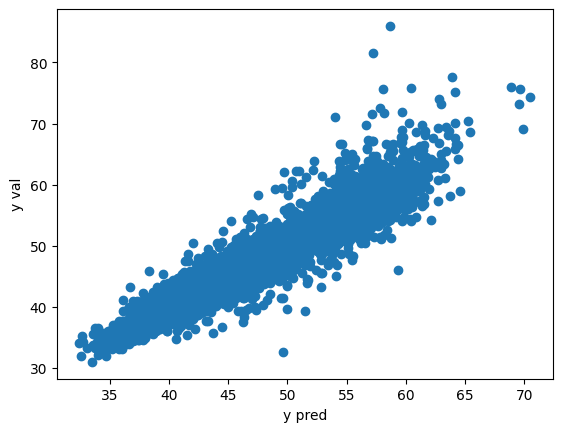

In [67]:
plt.scatter(val_preds, y_val["laeq"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [68]:
r2_score(val_preds, y_val["laeq"])

0.8999985346992687

In [69]:
## save model 

import pickle

pickle.dump(xgb, open('/content/drive/MyDrive/MDA_TIEN/xgb_laeq.pkl', 'wb'))

## Predict lceq

In [165]:
# Define the model parameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'max_depth': randint(3, 50),
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }
    },
    
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 1),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
        }
    }
    
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train['lceq'])
    
    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

Running RandomizedSearchCV for random_forest...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 85}
Best score for random_forest:  0.868648156962603


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.4289589971546303, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 71}
Best score for gradient_boosting:  0.8891690917785272


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.13316944575925016, 'learning_rate': 0.2717062903368829, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 98, 'reg_alpha': 0.19335562339240953, 'reg_lambda': 0.100473971701034}
Best score for xgboost:  0.9038449405707099




In [166]:
# Save optimal param dictionary
pickle.dump(params_dict,open("/content/drive/MyDrive/MDA_TIEN/lceq_dict","wb"))

In [71]:
# Load param dictionary 
lceq_dict = pickle.load(open("/content/drive/MyDrive/MDA_TIEN/lceq_dict", "rb"))
lceq_dict

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [72]:
gb_params = lceq_dict['gradient_boosting']

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["lceq"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lceq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lceq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lceq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lceq"]))

Train RMSE: 1.2308878685146232
Val RMSE: 1.7629257166930152
Train MAE: 0.8542538359355609
Val MAE: 1.1745026133304561


In [73]:
rf_params = lceq_dict['random_forest']

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["lceq"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lceq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lceq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lceq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lceq"]))

Train RMSE: 1.0042561072708873
Val RMSE: 1.930555705572765
Train MAE: 0.6709732152245396
Val MAE: 1.2981898413384934


In [74]:
import xgboost

xgb_params = lceq_dict['xgboost']

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["lceq"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lceq"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lceq"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lceq"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lceq"]))

Train RMSE: 0.932448384774181
Val RMSE: 1.6372958460950429
Train MAE: 0.649242584635434
Val MAE: 1.0750745589946153


Text(0, 0.5, 'y val')

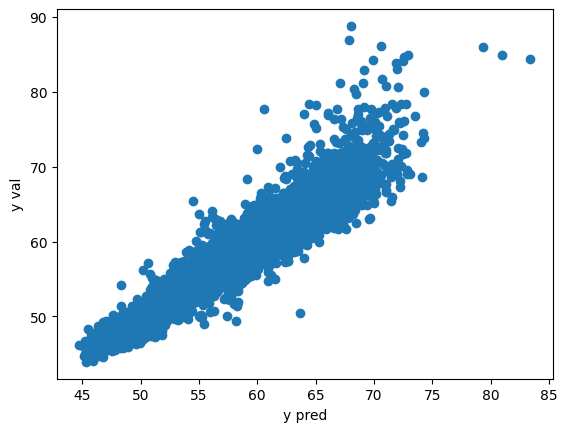

In [78]:
plt.scatter(val_preds, y_val["lceq"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [77]:
r2_score(val_preds, y_val["lceq"])

0.9074528455168079

In [79]:
## save model 

import pickle

pickle.dump(xgb, open('/content/drive/MyDrive/MDA_TIEN/xgb_lceq.pkl', 'wb'))

## predict lcpeak

In [167]:
# Define the model parameters
model_params = {
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'max_depth': randint(3, 50),
            'max_features': ['auto', 'sqrt'],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10),
            'bootstrap': [True, False]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_samples_split': randint(2, 20),
            'min_samples_leaf': randint(1, 10)
        }
    },
    
    'xgboost': {
        'model': xgboost.XGBRegressor(),
        'params': {
            'n_estimators': randint(50, 100),
            'learning_rate': uniform(0.01, 0.5),
            'max_depth': randint(1, 10),
            'min_child_weight': randint(1, 10),
            'gamma': uniform(0, 1),
            'reg_alpha': uniform(0, 1),
            'reg_lambda': uniform(0, 1),
        }
    }
    
}

params_dict = {}

# Loop through each model in model_params and run RandomizedSearchCV
for model_name, model_info in model_params.items():
    print("Running RandomizedSearchCV for {}...".format(model_name))
    
    # Create a RandomizedSearchCV object for the current model
    model = model_info['model']
    param_dist = model_info['params']
    random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                       n_iter=10, cv=5, n_jobs=1, random_state=7)
    
    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train['lcpeak'])
    
    # Print the best parameters and score
    params_dict[model_name] = random_search.best_params_
    print("Best parameters for {}: ".format(model_name), random_search.best_params_)
    print("Best score for {}: ".format(model_name), random_search.best_score_)
    print("\n")

Running RandomizedSearchCV for random_forest...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 85}
Best score for random_forest:  0.8665692615410485


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.4289589971546303, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 71}
Best score for gradient_boosting:  0.8862900710824549


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.13316944575925016, 'learning_rate': 0.2717062903368829, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 98, 'reg_alpha': 0.19335562339240953, 'reg_lambda': 0.100473971701034}
Best score for xgboost:  0.9020197977106068




In [168]:
# Save optimal param dictionary
pickle.dump(params_dict,open("/content/drive/MyDrive/MDA_TIEN/lcpeak_dict","wb"))

In [80]:
# Load param dictionary 
lcpeak_dict = pickle.load(open("/content/drive/MyDrive/MDA_TIEN/lcpeak_dict", "rb"))
lcpeak_dict

{'random_forest': {'bootstrap': False,
  'max_depth': 31,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 6,
  'n_estimators': 85},
 'gradient_boosting': {'learning_rate': 0.4289589971546303,
  'max_depth': 8,
  'min_samples_leaf': 8,
  'min_samples_split': 2,
  'n_estimators': 71},
 'xgboost': {'gamma': 0.13316944575925016,
  'learning_rate': 0.2717062903368829,
  'max_depth': 9,
  'min_child_weight': 4,
  'n_estimators': 98,
  'reg_alpha': 0.19335562339240953,
  'reg_lambda': 0.100473971701034}}

In [81]:
gb_params = lcpeak_dict['gradient_boosting']

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["lcpeak"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 1.2281198657500612
Val RMSE: 1.7569921462489921
Train MAE: 0.8588264771216795
Val MAE: 1.1805057522253848


In [82]:
rf_params = lcpeak_dict['random_forest']

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["lcpeak"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 0.9659273783157202
Val RMSE: 1.8517733426245717
Train MAE: 0.6464785007176574
Val MAE: 1.25212618740849


In [83]:
import xgboost

xgb_params = lcpeak_dict['xgboost']

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["lcpeak"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["lcpeak"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["lcpeak"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["lcpeak"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["lcpeak"]))

Train RMSE: 0.9276570802985057
Val RMSE: 1.5889109872385543
Train MAE: 0.6519813332222163
Val MAE: 1.0586098749995325


Text(0, 0.5, 'y val')

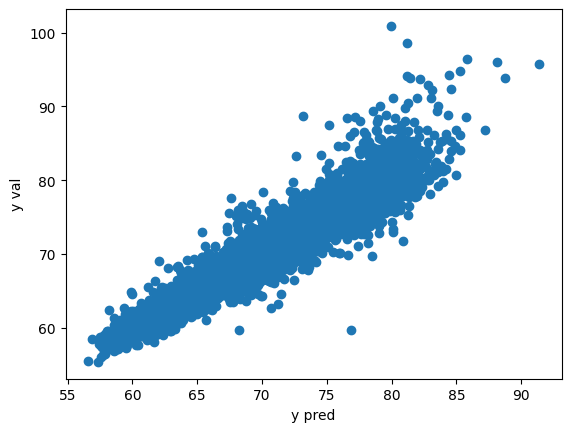

In [84]:
plt.scatter(val_preds, y_val["lcpeak"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [85]:
r2_score(val_preds, y_val["lcpeak"])

0.906577081950336

In [86]:
## save model 

import pickle

pickle.dump(xgb, open('/content/drive/MyDrive/MDA_TIEN/xgb_lcpeak.pkl', 'wb'))